## MonReader

In this project, images containing document pages being flipped or being held straight (no flipping) are used to train a Convolutional Neural Network which is then used to predict if pages are being flipped or not in test images.

In [61]:
import os
import shutil #file management module
import cv2 #openCV module
import pywt #wavelet transform module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

from sklearn.metrics import classification_report, confusion_matrix

## Define paths containing training and testing images

In [62]:
#define paths which contain training and testing images
training_data_path = './images/training/'
testing_data_path = './images/testing/'

## Visualize images

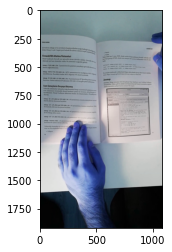

In [4]:
#An example of an image of pages NOT being flipped
img_test = cv2.imread('./test/noflip.jpg')
plt.imshow(img_test, cmap='gray')

In [5]:
img_test.shape

(1920, 1080, 3)

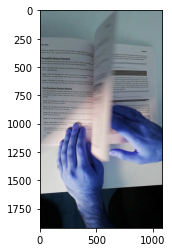

In [6]:
# An example of an image where the page is being flipped
img_test = cv2.imread('./test/flip.jpg')
plt.imshow(img_test, cmap='gray')

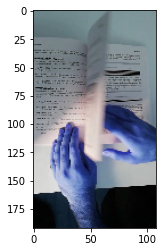

In [49]:
# Resize the first image to  a smaller one while maintaining the aspect ratio
scaled_test = cv2.resize(img_test, (108,192))
plt.imshow(scaled_test)

In [50]:
scaled_test.shape

(192, 108, 3)

## Create lists of directories containing training and testing images

In [9]:
#create a list of directories that contain TRAINING images
training_img_dirs = []
for entry in os.scandir(training_data_path):
    if entry.is_dir: #if entry is a directory
        training_img_dirs.append(entry.path) #append the directory path to the list

In [10]:
training_img_dirs

['./images/training/flip', './images/training/notflip']

In [11]:
#create a list of directories that containing TESTING images
testing_img_dirs = []

for entry in os.scandir(testing_data_path):
    if entry.is_dir:
        testing_img_dirs.append(entry.path)

In [12]:
testing_img_dirs

['./images/testing/flip', './images/testing/notflip']

## Resize all images and stack them in an array for training the Convolutional Neural Network model

## 1) Training images

In [51]:
# for the training data, an array consisting of the stacked arrays of resized original images along with a 
# list of labels (flip = 1 or nonflip = 0)

X_train = np.empty(shape = (0,192,108,3)) # independent variable array
y_train = [] # dependent varibale list

for img_dir in training_img_dirs:
    for file in os.scandir(img_dir):
        #print(file.path)
        img = cv2.imread(file.path) #read the image file
        scaled_img = cv2.resize(img, (108,192)) #resize the image
        X_train = np.vstack((X_train,scaled_img.reshape(1,192,108,3)))#stack to X_train
        #create y list (dependent varibale)
        if 'notflip' in img_dir:
            y_train.append(0)
        else:
            y_train.append(1)       

In [52]:
y_train = np.array(y_train).astype('float16')
y_train

array([1., 1., 1., ..., 0., 0., 0.], dtype=float16)

In [53]:
X_train.shape

(2392, 192, 108, 3)

In [54]:
X_train[0][0]

array([[116., 137., 145.],
       [110., 139., 143.],
       [111., 138., 142.],
       [111., 138., 142.],
       [117., 137., 142.],
       [116., 137., 139.],
       [112., 139., 140.],
       [110., 138., 139.],
       [112., 140., 141.],
       [113., 138., 140.],
       [117., 138., 140.],
       [117., 138., 140.],
       [115., 136., 138.],
       [111., 139., 140.],
       [118., 138., 141.],
       [118., 137., 140.],
       [120., 139., 144.],
       [115., 140., 142.],
       [118., 139., 141.],
       [120., 140., 145.],
       [120., 140., 145.],
       [119., 139., 144.],
       [118., 138., 143.],
       [118., 138., 143.],
       [116., 141., 143.],
       [115., 140., 142.],
       [114., 142., 143.],
       [115., 140., 142.],
       [115., 140., 142.],
       [115., 142., 146.],
       [116., 141., 143.],
       [115., 140., 142.],
       [119., 138., 141.],
       [116., 144., 145.],
       [118., 145., 149.],
       [119., 144., 146.],
       [120., 148., 149.],
 

In [55]:
#normalize X_train
X_train_norm = X_train/255
X_train_norm[0][0]

array([[0.45490196, 0.5372549 , 0.56862745],
       [0.43137255, 0.54509804, 0.56078431],
       [0.43529412, 0.54117647, 0.55686275],
       [0.43529412, 0.54117647, 0.55686275],
       [0.45882353, 0.5372549 , 0.55686275],
       [0.45490196, 0.5372549 , 0.54509804],
       [0.43921569, 0.54509804, 0.54901961],
       [0.43137255, 0.54117647, 0.54509804],
       [0.43921569, 0.54901961, 0.55294118],
       [0.44313725, 0.54117647, 0.54901961],
       [0.45882353, 0.54117647, 0.54901961],
       [0.45882353, 0.54117647, 0.54901961],
       [0.45098039, 0.53333333, 0.54117647],
       [0.43529412, 0.54509804, 0.54901961],
       [0.4627451 , 0.54117647, 0.55294118],
       [0.4627451 , 0.5372549 , 0.54901961],
       [0.47058824, 0.54509804, 0.56470588],
       [0.45098039, 0.54901961, 0.55686275],
       [0.4627451 , 0.54509804, 0.55294118],
       [0.47058824, 0.54901961, 0.56862745],
       [0.47058824, 0.54901961, 0.56862745],
       [0.46666667, 0.54509804, 0.56470588],
       [0.

## 2) Testing images

In [56]:
#create similar arrays of stacked images as above but now for the testing images as well as labels

X_test = np.empty(shape = (0,192,108,3)) # independent variable list
y_test = [] # dependent varibale list

for img_dir in testing_img_dirs:
    for file in os.scandir(img_dir):
        #print(file.path) #print the file path just to keep track of the progress
        img = cv2.imread(file.path) #read the image file
        scaled_img = cv2.resize(img, (108,192)) #resize the image
        X_test = np.vstack((X_test , scaled_img.reshape(1,192,108,3))) #stack to X_test
        #create the y list
        if 'notflip' in img_dir:
            y_test.append(0)
        else:
            y_test.append(1)

In [57]:
X_test.shape

(597, 192, 108, 3)

In [58]:
y_test = np.array(y_test).astype('float16')

In [59]:
#normalize X_test
X_test_norm = X_test/255

## Create a Convolutional Neural Network Model

In [68]:
#setup the model
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (192,108,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
          
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [69]:
#compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
         metrics=['accuracy'])

In [70]:
# train the model
model.fit(X_train_norm, y_train, epochs = 5, validation_data = (X_test_norm, y_test))

Epoch 1/5
75/75 [==============================] - 50s 655ms/step - loss: 0.5634 - accuracy: 0.7400 - val_loss: 0.2812 - val_accuracy: 0.8844
Epoch 2/5
75/75 [==============================] - 47s 632ms/step - loss: 0.1412 - accuracy: 0.9482 - val_loss: 0.1552 - val_accuracy: 0.9347
Epoch 3/5
75/75 [==============================] - 52s 694ms/step - loss: 0.0853 - accuracy: 0.9712 - val_loss: 0.0742 - val_accuracy: 0.9765
Epoch 4/5
75/75 [==============================] - 55s 730ms/step - loss: 0.0355 - accuracy: 0.9895 - val_loss: 0.0453 - val_accuracy: 0.9866
Epoch 5/5
75/75 [==============================] - 49s 653ms/step - loss: 0.0119 - accuracy: 0.9979 - val_loss: 0.0809 - val_accuracy: 0.9682


Even after just 5 epochs, the model accuracy is close to 100%. In order to keep the model generalized, we will define another model and stop after just 2 epochs and keep the accuracy used 95%

In [148]:
#setup the model
model2 = Sequential()

model2.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', input_shape = (192,108,3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
          
model2.add(Flatten())
model2.add(Dense(64, activation = 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(32, activation = 'relu'))
model2.add(Dropout(0.3))
model2.add(Dense(1, activation = 'sigmoid'))

In [149]:
#compile the model
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
         metrics=['accuracy'])

In [150]:
# train the model
model2.fit(X_train_norm, y_train, epochs = 3)

Epoch 1/3
75/75 [==============================] - 59s 780ms/step - loss: 0.7124 - accuracy: 0.6012
Epoch 2/3
75/75 [==============================] - 49s 650ms/step - loss: 0.5244 - accuracy: 0.7441
Epoch 3/3
75/75 [==============================] - 45s 595ms/step - loss: 0.3205 - accuracy: 0.8650


<AxesSubplot:>

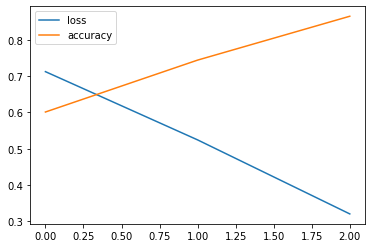

In [151]:
loss_df = pd.DataFrame(model2.history.history)
loss_df.plot()
# during the first 20 epochs, validation loss (orange line) decreases in tandem with the training loss (blue line)
# There is no sign of overfitting and we will use this trained model for predictions below

In [152]:
model2.evaluate(X_test_norm, y_test)

19/19 [==============================] - 4s 189ms/step - loss: 0.2321 - accuracy: 0.8945


[0.23209962248802185, 0.8944723606109619]

## Classify test images

In [153]:
#convert predicted values above 0.5 to 1. Lower values converted to 0.
y_pred = (model2.predict(X_test_norm)>0.5).astype('int16')

In [154]:
y_pred[280:300] # predictions where images transition from 'flip' to 'notflip'

array([[1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int16)

In [155]:
print(classification_report(y_test, y_pred)) # the classification metrics are good but unlike with 
# running the model for 20 epochs, the metrics are not perfect. It is hoped that this will keep the model generalized

              precision    recall  f1-score   support

         0.0       0.92      0.87      0.89       307
         1.0       0.87      0.92      0.89       290

    accuracy                           0.89       597
   macro avg       0.90      0.90      0.89       597
weighted avg       0.90      0.89      0.89       597



In [156]:
print(confusion_matrix(y_test, y_pred))

[[266  41]
 [ 22 268]]


All classification metrics are very good without any model optimization

## Create a function to classify if a single image where the page is being flipped or not

In [134]:
# function to predict if a page is being flipped or not using a single image (provide file path and file name)

def predict_flip (image, print_output):
    img = cv2.imread(image)
    scaled_img = cv2.resize(img, (108,192))
    img_norm = (scaled_img/255).reshape(1,192,108,3)
    y_pred = (model2.predict(img_norm)>0.5).astype('int16')
    if print_output == 'Y':
        if y_pred == 0:
            print('This is not an image of page flipping')
        else: print('This is an image of a page being flipped')
    else: return y_pred

In [157]:
predict_flip('./test/noflip.jpg', 'Y') #the model correctly predicts an image where the page is notbeing flipped

This is not an image of page flipping


## Create a function to detect if a sequence of images contain an image where the page is being flipped

In [96]:
# function to predict if a series of images contain an image of a page being flipped. Folder containing the images to be 
# provided as folder path

def image_series (folder_path):
    X_seq = np.empty(shape = (0,192,108,3))
    for file in os.scandir(folder_path):
        img = cv2.imread(file.path) 
        scaled_img = cv2.resize(img, (108,192))
        img_norm = (scaled_img/255).reshape(1,192,108,3)
        X_seq = np.vstack((X_seq,img_norm))#stack
        y_predict = (model2.predict(X_seq)>0.5).astype('int16')
        
    if 1 in y_predict:
        print('Flipping action is detected in the image sequence')
    else: print('Flipping action is NOT detected in the image sequence')
    return y_predict   

In [138]:
img_seq_path = './test_sequence/'

In [158]:
image_series(img_seq_path) #the image sequence has several images where the page is being turned.
# This is correctly identified by the above function using the trained model

Flipping action is detected in the image sequence


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int16)

## Test the model's ability to classify images taken by me

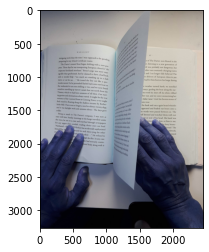

In [177]:
for file in os.scandir('./my_images/'):
    img_plt = cv2.imread(file.path)
    plt.imshow(img_plt, cmap='gray')

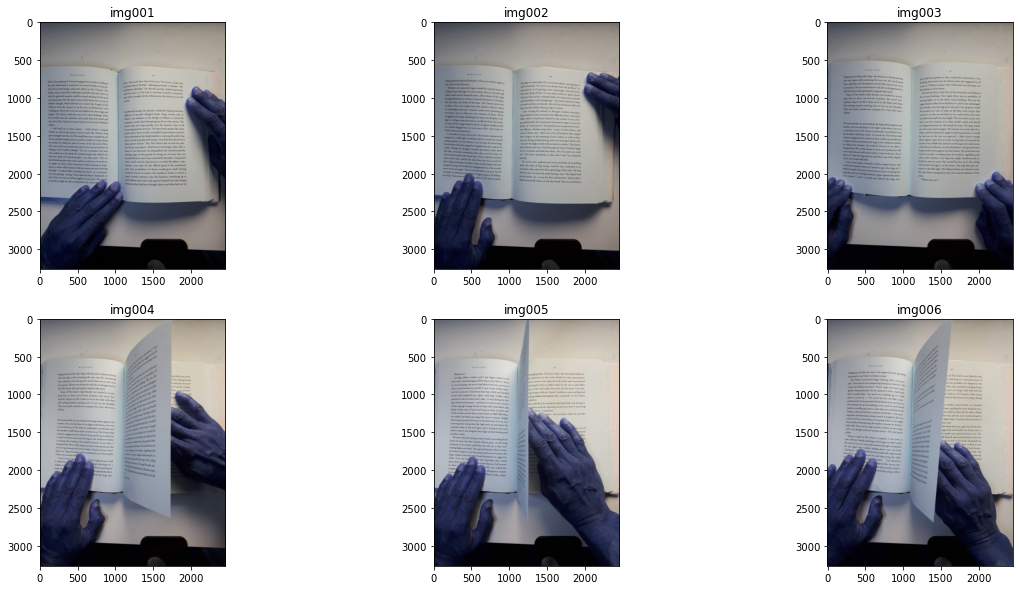

In [202]:
#following 6 images were tested using the model

ind = 1
plt.subplots(figsize=(20,10))
for file in os.scandir('./my_images/'):
    plt.subplot(2, 3, ind)
    img_plt = cv2.imread(file.path)
    plt.imshow(img_plt, cmap='gray')
    plt.title('img00'+str(ind))
    ind +=1

In [207]:
for file in os.scandir('./my_images/'):
    print('IMG FILE: ',file.path)
    predict_flip(file.path, 'Y')
    
# all the test images were classified as 'flip'
# This indicates that though the model performs accurately with the original dataset, it is not generalized enough to classify
# images from different sources

IMG FILE:  ./my_images/img001.jpg
This is an image of a page being flipped
IMG FILE:  ./my_images/img002.jpg
This is an image of a page being flipped
IMG FILE:  ./my_images/img003.jpg
This is an image of a page being flipped
IMG FILE:  ./my_images/img004.jpg
This is an image of a page being flipped
IMG FILE:  ./my_images/img005.jpg
This is an image of a page being flipped
IMG FILE:  ./my_images/img006.jpg
This is an image of a page being flipped


## Concluding Remarks

A simple Convolutional Neural Network model was able to easily detect if an image file contains an image of a page being flipped or not. All classification metrics were around 90% indicating the model is performing robustly. However, it appears that the model is not generalized to accurately classify images that are not part of the original dataset. Even the images where the page was not flipped, were detected as page flipping